In [1]:
import os
import math

PATH = os.path.abspath("test.ipynb")
DATA = os.path.join(os.path.dirname(PATH), "data/output_optical_7.txt")
# DATA = "/home/twig/shared/data/babycal/output.txt"

HBANK  = "header bank"
UHBANK = "user header bank"
IRBANK = "integrated raw bank"
IDBANK = "integrated digitized bank"
GPBANK = "generated particles bank"

# Define these based on the input file.
NROWS = 11
NCOLS = 11

# Do not touch these constants!
STRIP_RADIUS = 0.050
CORE_RADIUS  = 0.046

In [2]:
# Store metadata as strings (for now).
def store_metadata(file):
    metadata = {}

    for i in range(2):
        devnull = file.readline() # Ignore the first two lines.

    while True:
        x = file.tell() # Define a stopping point for later (a bit dirty but it's not too bad).
        l = file.readline()
        if l[3] != '>': break # From this point we begin reading events.
        sl = l.split(' ')
        if len(sl) == 7:
            metadata[sl[5]] = sl[6][:-1]
    devnull = file.seek(x)
    
    return metadata

In [3]:
# Store event data in "struct":
#     event_data[0] : header bank (10).
#     event_data[1] : user header bank (currently empty). Assumed to have same format as header bank.
#     event_data[2] : integrated raw bank (51).
#     event_data[3] : integrated digitized bank (52).
#     event_data[4] : generated particles bank.
# Assumes that the file's metadata has already been stored.
def store_event(file):
    event_data = {
        HBANK  : {},
        UHBANK : {},
        IRBANK : {},
        IDBANK : {},
        GPBANK : {},
    }
    bank = None
    eof = 0 # End of file checker.

    while True:
        l = file.readline()
        l = l[:-1].rstrip()
        if l == " ---- End of Event  ----": 
            break
        if l == '':
            eof = 1
            break

        # Make sure we're writing to the correct address.
        if   l == " --- Header Bank --":                          bank = HBANK
        elif l == " --- User Header Bank --":                     bank = UHBANK
        elif l == "   -- integrated true infos bank  (51, 0) --": bank = IRBANK
        elif l == "   -- integrated digitized bank  (52, 0) --":  bank = IDBANK
        elif l == " --- Generated Particles Bank --":             bank = GPBANK

        if bank != GPBANK:
            sl = l.split('\t')
            if len(sl) == 1: continue # Ignore lines with titles & additional information.

        if bank == HBANK or bank == UHBANK: # Header & user header banks.
            event_data[bank][sl[0].split(' ')[-1][:-1]] = sl[1]
        if bank == IRBANK or bank == IDBANK: # Raw & Digitized banks.
            event_data[bank][sl[0].split(' ')[-1][:-1]] = sl[1:]
        if bank == GPBANK: # Generated particles bank.
            sl = l.split()
            if sl[1] == 'Particle':
                event_data[bank][sl[ 3][:-1]] = sl[ 4]
                event_data[bank][sl[ 6][:-1]] = sl[ 7]
                event_data[bank][sl[10][:-1]] = sl[11]
            if sl[1] == 'Hit':
                event_data[bank]['nhits'] = sl[ 4]
                event_data[bank][sl[ 7]]  = sl[ 8]
                event_data[bank][sl[11]]  = sl[12]
    if eof != 0:
        return None
    
    return event_data

In [4]:
# Create a dictionary with the events' hits.
def generate_raw_hits(event_data):
    if event_data == None: return None
    hits = {"hitn" : [], # Hit identifier number.
            "id"   : [], # ID of the body hit by the particle, used to obtain the hit's position.
            "time" : [], # Time when the hit happened.
            "edep" : [], # Energy Deposited.
    }
    for pi in range(len(event_data[IDBANK]["hitn"])):
        if event_data[IRBANK]["pid"][pi] == '0': continue # Ignore events from 0 energy photons.
        hits["hitn"].append(int  (event_data[IDBANK]["hitn"][pi]))
        hits["id"]  .append(int  (event_data[IDBANK]["id"][pi]))
        hits["time"].append(float(event_data[IRBANK]["avg_t"][pi]))
        hits["edep"].append(float(event_data[IRBANK]["totEdep"][pi]))

    return hits

# Print all hits from a hits dictionary.
def print_hits(hits):
    if hits == None: return None
    for i in range(len(hits["hitn"])): print("%3d - %3d : %f" % (hits["hitn"][i], hits["id"][i], hits["edep"][i]))

In [5]:
# Remove the hits that didn't impact the scintillator fibers.
# TODO: Filtering needs to be further refined based on what would be perceived in the real world.
def filter_hits(hits, nrows, ncols):
    if hits == None: return None
    nvolumes = (ncols*((nrows+1)/2) + (ncols-1)*((nrows-1)/2))*3 + 3

    nrowsa = (nrows + 1)/2
    nrowsb = (nrows - 1)/2

    lowerlimit_a = 1
    upperlimit_a = nrowsa*ncols
    lowerlimit_b = 3*nrowsa*ncols + 1
    upperlimit_b = 3*nrowsa*ncols + nrowsb*(ncols-1)

    marked_for_removal = []

    for i in range(len(hits["id"])):
        # Check if id is valid.
        if lowerlimit_a > hits["id"][i]:
            print("Volume ID is negative! Input file is malformed.")
            return None
        if hits["id"][i] > nvolumes:
            print("Volume ID is invalid! `nrows` or `ncols` might be set up wrong.")
            return None

        # Check if id is within a sensitive volume.
        approved = False
        if lowerlimit_a <= hits["id"][i] and hits["id"][i] <= upperlimit_a: approved = True
        if lowerlimit_b <= hits["id"][i] and hits["id"][i] <= upperlimit_b: approved = True
        if not approved: marked_for_removal.append(i)

    for i in marked_for_removal[::-1]:
        hits["hitn"].pop(i)
        hits["id"]  .pop(i)
        hits["time"].pop(i)
        hits["edep"].pop(i)

# Derive xy position of each volume based on id.
def decompose_id(id, nrows, ncols):
    nrowsa = (nrows + 1)/2
    nrowsb = (nrows - 1)/2

    lowerlimit_a = 1
    upperlimit_a = nrowsa*ncols
    lowerlimit_b = 3*nrowsa*ncols + 1
    upperlimit_b = 3*nrowsa*ncols + nrowsb*(ncols-1)
    
    alpha = STRIP_RADIUS * 1.732050808 + STRIP_RADIUS # auxiliary constant for computing y distance.
    delta_x = (2.*STRIP_RADIUS * ncols)/2.
    delta_y = (2.*STRIP_RADIUS + (nrows - 1) * alpha)/2.
    
    if   lowerlimit_a <= id and id <= upperlimit_a: # fiber a
        nx = math.floor((id-1)/nrowsa)
        ny = (id-1) % nrowsa
        x = (-delta_x + STRIP_RADIUS) + (0.1     * nx)
        y = (-delta_y + STRIP_RADIUS) + (2*alpha * ny)
    elif lowerlimit_b <= id and id <= upperlimit_b: # fiber b
        idb = id - (3*nrowsa*ncols)
        nx = math.floor((idb-1)/nrowsb)
        ny = (idb-1) % nrowsb
        x = (-delta_x + 2*STRIP_RADIUS) + 2*STRIP_RADIUS * nx
        y = (-delta_y +   STRIP_RADIUS) + alpha + 2*alpha * ny
    else:
        print("Invalid hit passed to decompose_id()! Filter the hits before decomposing them.")
        return None

    return (x,y)

# Produce hit time based on event number and time (not sure how yet).
def define_time(nevent, time):
    return nevent + time

# Process raw hits into coherent objects
def process_hits(raw_hits, nevent, nrows, ncols):
    if raw_hits == None: return None
    processed_hits = {"x" : [], # x position of the strip closest to the hit.
                      "y" : [], # y position of the strip closest to the hit.
                      "t" : [], # generated time of the hit.
                      "E" : [], # energy deposited.
    }
    filter_hits(raw_hits, nrows, ncols)
    for i in range(len(raw_hits["hitn"])):
        (x, y) = decompose_id(raw_hits["id"][i], nrows, ncols)
        t = define_time(nevent, raw_hits["time"][i])
        E = raw_hits["edep"][i]
        
        processed_hits["x"].append(x)
        processed_hits["y"].append(y)
        processed_hits["t"].append(t)
        processed_hits["E"].append(E)
    return processed_hits

In [6]:
import numpy as np
from scipy.sparse import csr_matrix

# Generate sparse matrices from hits.
def generate_hit_matrices(hits):
    # Hits should be a dictionary with the format:
    # 'x' : array of hits' x position.
    # 'y' : array of hits' y position.
    # 
    (x,y)

# Sanity Checks
### Position check
Check all data and make sure that all errors are less than 0.05cm.

In [7]:
f = open(DATA)
metadata = store_metadata(f)

error = [0., 0.]
nhits = 0

while True:
    event = store_event(f)
    if event == None: break
    rhits = generate_raw_hits(event)
    filter_hits(rhits, NROWS, NCOLS)
    
    for i in range(len(rhits["hitn"])):
        # HIT COORDINATES
        idx = 0
        for j in range(len(event[IDBANK]["hitn"])):
            if int(event[IDBANK]["hitn"][j]) == rhits["hitn"][i]: idx = j
        hit_x = float(event[IRBANK]["avg_x"][idx])/10.
        hit_y = float(event[IRBANK]["avg_y"][idx])/10.
        
        # STRIP COORDINATES
        (strip_x, strip_y) = decompose_id(rhits["id"][i], NROWS, NCOLS)

        # CALC DIFF
        error_x = abs(hit_x - strip_x)
        error_y = abs(hit_y - strip_y)
        if error_x > CORE_RADIUS or error_y > CORE_RADIUS:
            print("Something is seriously wrong. Difference between hit and strip is larger than core radius!")
        
        nhits += 1
        error[0] += error_x
        error[1] += error_y
        
for i in range(len(error)): error[i] = error[i]/nhits
print(error)

f.close()

[0.02274157853051755, 0.03462745261439327]


**Time check**: Plot the `avg_t` variable vs the event number.

In [8]:
f = open(DATA)
metadata = store_metadata(f)

eventCount = []
timeList   = []

ei = 0
while True:
    ei += 1
    event = store_event(f)
    if event == None: break
    if ei == 101: break
    for t in event[IRBANK]["avg_t"]:
        eventCount.append(ei)
        timeList.append(float(t))

f.close()

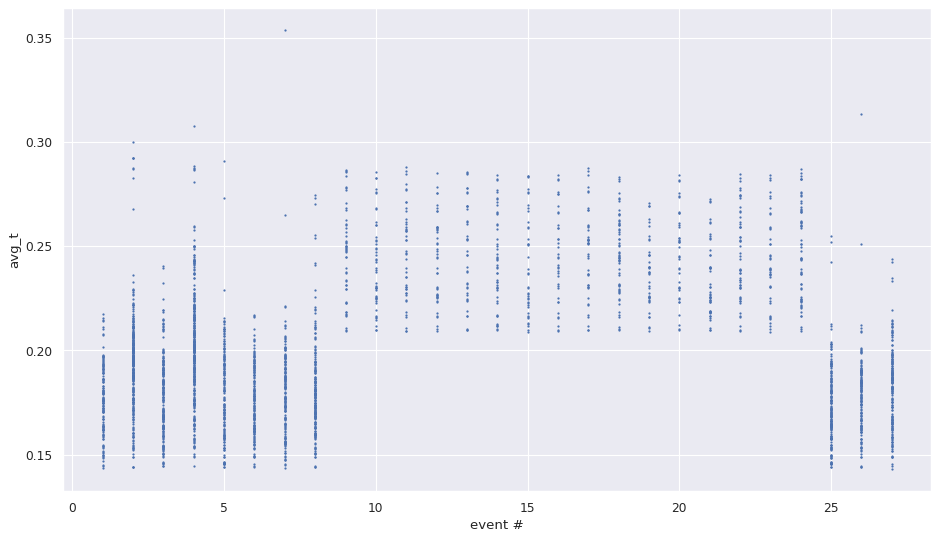

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
sns.set_theme()

plt.scatter(eventCount, timeList, s=1)
plt.xlabel("event #")
plt.ylabel("avg_t")
plt.show()

**Hit processing check**: Check that the raw hits are processed correctly.

In [27]:
all_hits = []

f = open(DATA)
metadata = store_metadata(f)

while True:
    event = store_event(f)
    if event == None: break

    rhits = generate_raw_hits(event)
    all_hits.append(process_hits(rhits, int(event[HBANK]["evn"]), NROWS, NCOLS))
f.close()

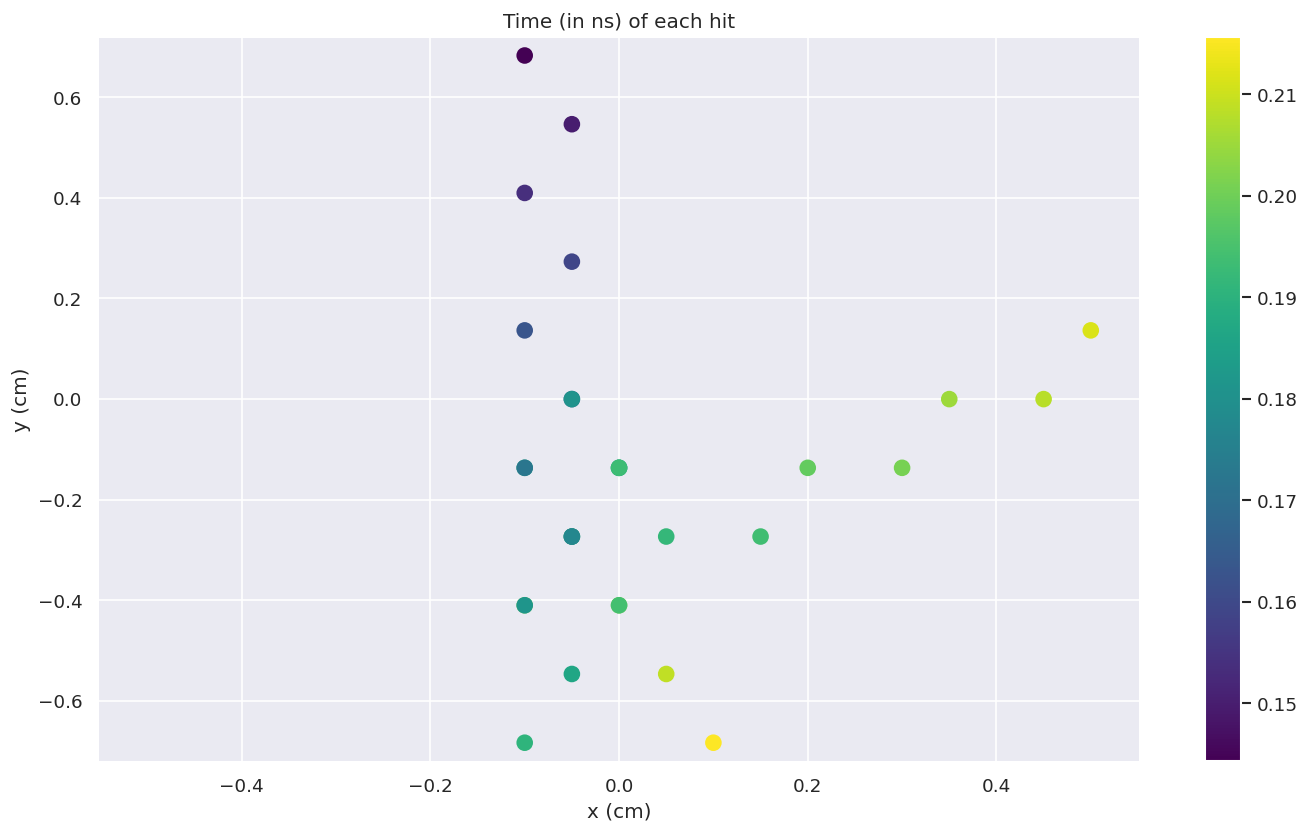

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

nevent = 1

DELTAX = (2.*CORE_RADIUS * NCOLS)/2. + CORE_RADIUS
DELTAY = (2.*CORE_RADIUS + (CORE_RADIUS * (1.732050808 + 1)) * (NROWS - 1))/2. + CORE_RADIUS

hits = all_hits[nevent]

fake_t = hits["t"].copy()
for i in range(len(fake_t)): fake_t[i] -= nevent + 1

figure(num=None, figsize=(14, 8), dpi=120, facecolor='w', edgecolor='k')
sns.set_theme()

plt.scatter(hits["x"], hits["y"], c=fake_t, s=80, cmap='viridis')
plt.title("Time (in ns) of each hit")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.xlim([-DELTAX, DELTAX])
plt.ylim([-DELTAY, DELTAY])
plt.colorbar()
plt.show()

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4, width=100, compact=True)